

# AMLS Assignment
## Task A_4: CNN Tuning on BreastMNIST Dataset

Explore CNN based classifiers on the BreastMNIST dataset.

## Import libraries
The required libraries for this notebook include numpy, matplotlib, tensorflow, medmnist and also a custom built dataload and utility library.

In [15]:
## first enable autoreload during development so latest (new) version local code library is reloaded on execution 
## can be commented out when local code development not happening to avoid overhead
%load_ext autoreload
%autoreload 2

## import libraries
import io
import os
import numpy as np
import matplotlib.pyplot as plt
## import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
## removed MedMNIST as only used in AMLS common library

## local code library
import AMLS_common as ac

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set base parameters
Including hyperparameters and environment specifics

In [16]:
filename = "param_2025_01_11_at_191919.xlsx"
if os.path.isfile(filename):
    item = ac.HyperParameters.load_excel(filename)
else:
    print(filename+" does not exist. Loading default hyperparameters instead")
    item      = ac.HyperParameters(learning_rate=0.001, 
                                   kernel_size=3, 
                                   num_epochs=15, 
                                   num_filter=32,
                                   layers=2,
                                   dropout_rate=0.1,
                                   optimise="Adam",
                                   strides=1,
                                   padding="same",
                                   loss="binary_crossentropy")
print(ac.HyperParameters.list_parameters(item))

learning_rate: 0.001
kernel_size: 3
num_epochs: 15
optimise: Adam
loss: binary_crossentropy
num_filter: 32
strides: 1
padding: same
dropout_rate: 0.1
layers: 2
default_activation: relu



In [17]:
# environment and control (e.g. verbose) parameters
data_labels =  ["malignant", "normal,benign"]
batch_size  = 128
filebase    = "metrics/"          ## where to store file outputs
verbose     = 1                   ## if value equals 1 then print additional process information in steps below

## Load and preprocess the BreastMNIST Data
We load the dataset.

In [18]:
## Loading the data file using custom MedMINST loader
data_flag  = 'breastmnist'       ## defines which dataset to load
result_set = ac.medMNIST_load(data_flag,batch_size)

## check that the loader returned data correctly and then split out
if result_set != []:
    train_dataset = result_set[0]
    test_dataset  = result_set[1]
    val_dataset   = result_set[2]

if verbose == 1:
    ## print out information on training dataset if verbose set
    print("\nSummary metrics for train_dataset")
    print("type:",type(train_dataset))
    print("length:",len(train_dataset))
    print("shape:",train_dataset)

Using downloaded and verified file: C:\Users\johnc\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\breastmnist.npz

Summary metrics for train_dataset
type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
length: 5
shape: <BatchDataset shapes: ((None, 28, 28, 1), (None, 1)), types: (tf.float64, tf.float32)>


## Define the CNN model

In [19]:
# Define the model
if verbose == 1:
    print("Default activation is ", item.default_activation)

    if item.layers == 2:
        model = Sequential([
            Conv2D(item.num_filter*2, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation, input_shape=(28, 28, 1)),  ## Input layer
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Dropout(item.dropout_rate),                                           ## Drop out to reduce possible over fitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Flatten(),                                                            ## Flatten
            Dense(item.num_filter*4,activation=item.default_activation),          ## Fully connected layer
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            Dropout(item.dropout_rate*2),                                         ## Drop out to reduce possible over fitting
            Dense(1, activation='sigmoid')                                        ## Output layer for binary classification  
        ])
    if item.layers == 3:
        model = Sequential([
            Conv2D(item.num_filter*2, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation, input_shape=(28, 28, 1)),  ## Input layer
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Dropout(item.dropout_rate),                                           ## Drop out to reduce possible over fitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Flatten(),                                                            ## Flatten
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            Dropout(item.dropout_rate*2),                                         ## Drop out to reduce possible over fitting
            Dense(1, activation='sigmoid')                                        ## Output layer for binary classification  
        ])
    if item.layers == -4:
    ## old version without dropouts
        model = Sequential([
            Conv2D(item.num_filter*2, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation, input_shape=(28, 28, 1)),  ## Input layer
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            ##Dropout(item.dropout_rate),                                           ## Drop out to reduce possible over fitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Conv2D(item.num_filter*2, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Flatten(),                                                            ## Flatten
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            ##Dropout(item.dropout_rate*2),                                         ## Drop out to reduce possible over fitting
            Dense(1, activation='sigmoid')                                        ## Output layer for binary classification  
        ])   
    if item.layers == 4:
        model = Sequential([
            Conv2D(item.num_filter*2, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation, input_shape=(28, 28, 1)),  ## Input layer
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Dropout(item.dropout_rate),                                           ## Drop out to reduce possible over fitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            Conv2D(item.num_filter, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Conv2D(item.num_filter*2, kernel_size=item.kernel_size, padding=item.padding,\
                   activation=item.default_activation),                           ## Another convolution layer
            MaxPooling2D((2, 2),strides=item.strides),                            ## Reduce the feature maps
            Flatten(),                                                            ## Flatten
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            Dense(item.num_filter*4, activation=item.default_activation),         ## Fully connected layer
            Dropout(item.dropout_rate*2),                                         ## Drop out to reduce possible over fitting
            Dense(1, activation='sigmoid')                                        ## Output layer for binary classification  
        ])   
if verbose == 1:
    print(model.summary())
# Redirect the summary output to a string
summary_string  = io.StringIO()
model.summary(print_fn=lambda x: summary_string.write(x + "\n"))
summary_content = summary_string.getvalue()
summary_string.close()

Default activation is  relu
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)       

## Fit the model

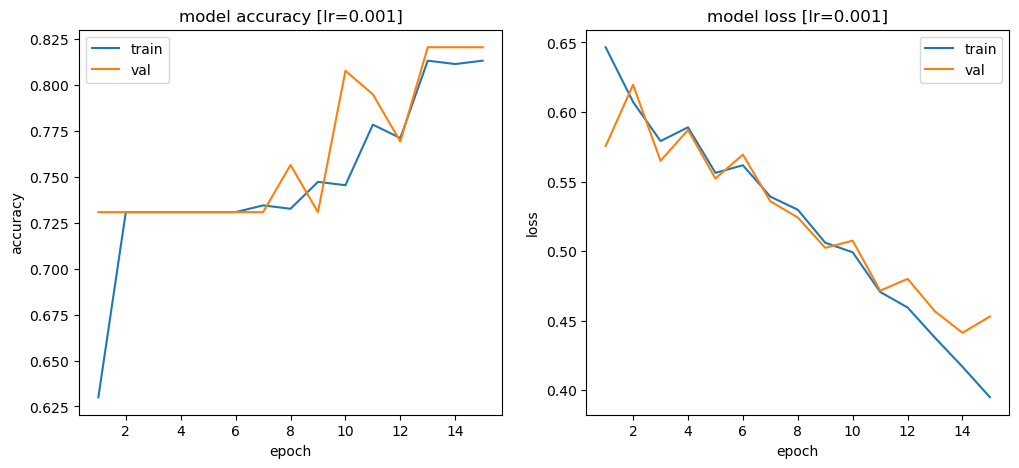

for model
 Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632) 

['metrics/metrics_2025_01_16_at_182027.xlsx',
 'metrics/summary_2025_01_16_at_182027.txt',
 RunResult(min_loss=0.3949691951274872, max_acc=0.8131868243217468, last_loss=0.3949691951274872, last_acc=0.8131868243217468, min_val_loss=0.4412839710712433, max_val_acc=0.8205128312110901, last_val_loss=0.45299965143203735, last_val_acc=0.8205128312110901, var_loss=0.005367186375287562, var_acc=0.0021277428947116947),
 HyperParameters(learning_rate=0.001, kernel_size=3, num_epochs=15, optimise='Adam', loss='binary_crossentropy', num_filter=32, strides=1, padding='same', dropout_rate=0.1, layers=2, default_activation='relu')]

In [20]:
## set up optimizer from hyperparameter structure
model.compile(optimizer=item.optimise,                                                   
              loss=item.loss,
              metrics='acc')

## Fit the model
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=item.num_epochs, 
                    batch_size=batch_size, 
                    verbose=0)

## output graphically and also save to files
ac.graph_and_save(history,summary_content,item,filebase)

Confusion Matrix:



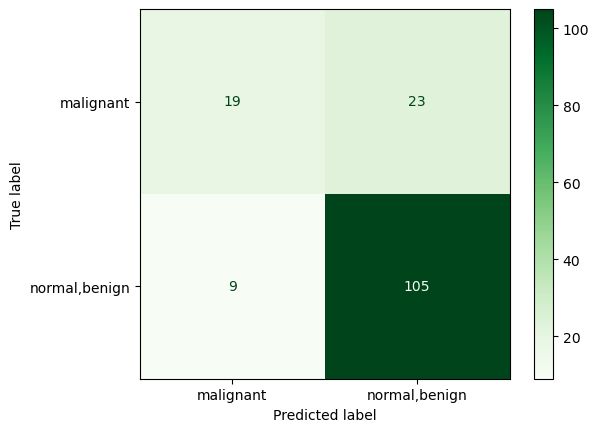

In [21]:
## take numpy version of test data to ease handling
x_test, y_test = ac.dataset_to_numpy(test_dataset)
prediction     = model.predict(x_test)
## double check data is in same format
prediction     = list(map(lambda x: 0 if x<0.5 else 1, prediction))
conf_matrix    = confusion_matrix(y_test, prediction)
## output confusion matrix
print("Confusion Matrix:\n")
disp           = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels = data_labels)
disp.plot(cmap='Greens')
plt.show()